# Requirements

In [178]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr

import nltk

import sddk
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import geoplot as gplt

In [172]:
# setup sciencedata, google and figures exports
# (feel free to skip...)

s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [175]:
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [5]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [6]:
LIRE[LIRE["is_western"]]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
210,EDCS-21300235,"CIL 06, 00882 (p 3777, 4302, 4367) = CIL 06, 3...",Aegyptus,Aegyptus,Al Iskandariyah / Alexandria,"['Al Iskandariyah', 'Alexandria']",20,,"['Augusti/Augustae', 'tituli sacri', 'viri']",tituli sacri,...,9998.65,1002,"[12.395451, 42.021684]",15756.86,large,[faber],1,[],0,"[Production and related workers, transport equ..."
281,EDCS-12800362,"AE 1964, 00222",Aemilia / Regio VIII,Aemilia / Regio VIII,Bagno di Romagna,Bagno di Romagna,200,,"['tituli sacri', 'viri']",tituli sacri,...,41767.45,937,"[11.903398, 43.983123]",17068.12,rural,[],0,[],0,[]
282,EDCS-09300206,"AE 1976, 00204",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
283,EDCS-09300210,"AE 1976, 00208",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['liberti/libertae', 'mulieres', 'tituli sepul...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
284,EDCS-09300215,"AE 1976, 00213",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",100,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136185,EDCS-10700071,"SupIt-12-IC, 00047 = IulCarnicum-02, 00125",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136186,EDCS-10700072,"SupIt-12-IC, 00048 = IulCarnicum-02, 00137",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136187,EDCS-10700073,"SupIt-12-IC, 00049 = IulCarnicum-02, 00134",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136188,EDCS-10700074,"SupIt-12-IC, 00050 = IulCarnicum-02, 00115",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",25,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]


In [7]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[]


In [8]:
# mask
before235 = LIRE["not_before"] < 235

In [9]:
len(LIRE[before235])

114898

In [10]:
LIRE[before235]["occups_N"].sum()

4751

In [11]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9168274797375531

In [182]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [117]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [183]:
len(set(["b", "b", "b"]))

1

In [185]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    city_data_pre235 = LIRE[(LIRE["city_ID"]==str(ID)) & (before235)]
    if len(city_data) > 0:
        # all inscriptions
        city_dict["inscr_N"] = len(city_data)
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_unique_N"] = len(set(city_dict["occups_list"]))
        city_dict["organizations_N"] = city_data["organizations_N"].sum()
        city_dict["organizations_list"] = [el for sublist in city_data["organizations"] for el in sublist]
    # inscriptions pre 235
        city_dict["inscr_N_pre235"] = len(city_data_pre235)
        city_dict["occups_N_pre235"] = city_data_pre235["occups_N"].sum()
        city_dict["ratio_pre235"] = len(city_data_pre235) / len(city_data)
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [186]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,occups_list,occups_N,occups_unique_N,organizations_N,organizations_list,inscr_N_pre235,occups_N_pre235,ratio_pre235
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,[],0.0,0.0,0.0,[],1.0,0.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [188]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [189]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,geometry,inscr_N,occups_list,occups_N,occups_unique_N,organizations_N,organizations_list,inscr_N_pre235,occups_N_pre235,ratio_pre235
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,POINT (22.93333 38.58333),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,POINT (23.73409 38.08347),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,POINT (23.21970 38.45261),1.0,[],0.0,0.0,0.0,[],1.0,0.0,1.0
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,POINT (23.42850 37.75007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,POINT (22.35572 38.14795),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# all cities
len(roman_cities)

1388

In [191]:
roman_cities["inscr_N"].sum()

109369.0

In [192]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

856

In [193]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6167146974063401

In [194]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [195]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

657

In [196]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.7390326209223848

# Focus on western cities alone - basic explorations (feel free to skip)

In [197]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [198]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])

roman_cities["pop_est_log10"] = np.log10(roman_cities["pop_est"])
roman_cities["inscr_N_log2"] = np.log2(roman_cities["inscr_N"])

roman_cities["occups_N_log"] = np.log2(roman_cities["occups_N"])


/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Measuring Specialization and Diversity

In [199]:
len(roman_cities)

889

In [200]:
(roman_cities["occups_N"]>0).sum()

313

In [201]:
roman_cities["occups_N"].max()

1855.0

In [202]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [203]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,organizations_N,organizations_list,inscr_N_pre235,occups_N_pre235,ratio_pre235,pop_est_log,inscr_N_log,pop_est_log10,inscr_N_log2,occups_N_log
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,0.0,[],0.0,0.0,0.000000,6.907755,0.000000,3.000000,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,0.0,[],37.0,4.0,0.822222,8.905987,3.806662,3.867821,5.491853,2.321928
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,0.0,[],435.0,9.0,0.917722,11.533453,6.161207,5.008915,8.888743,3.169925
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,0.0,[],0.0,0.0,0.000000,6.907755,0.693147,3.000000,1.000000,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,0.0,[],9.0,2.0,0.692308,10.480803,2.564949,4.551755,3.700440,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,0.0,[],107.0,1.0,0.891667,10.247432,4.787492,4.450403,6.906891,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,0.0,[],5.0,1.0,0.833333,9.351579,1.791759,4.061339,2.584963,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,0.0,[],23.0,2.0,0.793103,8.521584,3.367296,3.700877,4.857981,1.000000
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,0.0,[],28.0,1.0,1.000000,8.405367,3.332205,3.650405,4.807355,0.000000


In [204]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [205]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclear meaning',
 'Water-Management'}

In [206]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Food-Production',
 'Glass-Working',
 'Plastic Arts',
 'Retail',
 'Building',
 'Food-Retail',
 'Water-Management',
 'Performing Arts',
 'Household Goods',
 'Managerial',
 'Fuel / Raw material',
 'Miscellaneous Services',
 'Metal-Working',
 'Death-care sector',
 'Clothing',
 'Education',
 'Transport',
 'Unclear meaning',
 'Finance']

In [207]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [208]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

Text(0, 0.5, 'N cities')

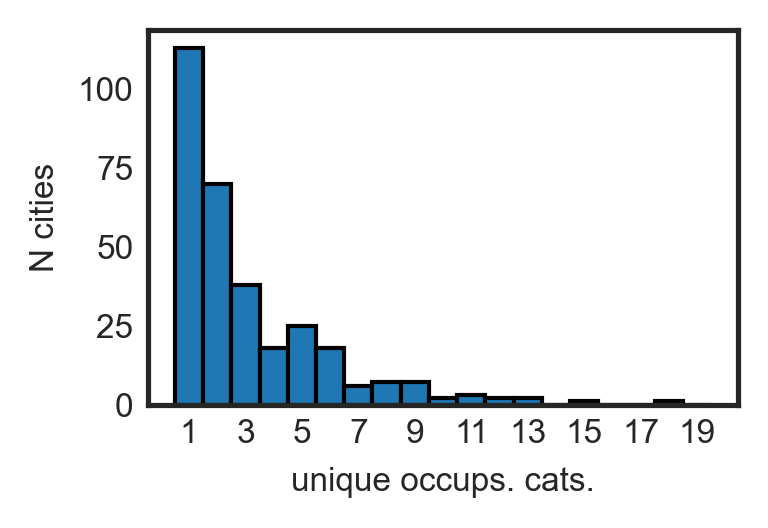

In [209]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [210]:
save_figure(fig, "unique_cats_per_cities_hist")

A file with the same name ("unique_cats_per_cities_hist.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.eps"
A file with the same name ("unique_cats_per_cities_hist.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.png"


In [211]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165     [Performing Arts, Managerial, Miscellaneous Se...
171     [Managerial, Miscellaneous Services, Manageria...
174                              [Miscellaneous Services]
177                        [Metal-Working, Metal-Working]
                              ...                        
1297                                      [Metal-Working]
1311                                      [Metal-Working]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 313, dtype: object

# Specialization

In [216]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)

In [217]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
165     [0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, ...
171     [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 1, 0, 0, ...
174     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
177     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...
                              ...                        
1297    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
1311    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
1315    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...
1317    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
1321    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...
Name: occups_cats_vec, Length: 313, dtype: object

In [218]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [219]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.000000
165     0.400000
171     0.666667
174     1.000000
177     1.000000
          ...   
1297    1.000000
1311    1.000000
1315    1.000000
1317    1.000000
1321    1.000000
Name: ZI, Length: 313, dtype: float64

In [296]:
roman_cities_wo["largest_cat"] = roman_cities_wo["occups_cats_vec"].apply(max)

In [297]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,ZI,ZI_cat,ZIw,shares_weighted_vec,RZI,RZI_cat,RZIw,DI,DIw,largest_cat
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.000000,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000,1
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,0.400000,Managerial,0.928771,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.41349693...",5.413497,Performing Arts,12.569751,3.571429,1.538131,2
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,0.666667,Miscellaneous Services,2.113283,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.968468,Miscellaneous Services,15.749672,1.975610,0.623235,6
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.000000,Miscellaneous Services,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.452703,Miscellaneous Services,0.000000,1.000000,0.000000,1
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,1.000000,Metal-Working,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.713675,Metal-Working,4.713675,1.000000,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.000000,Metal-Working,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.713675,Metal-Working,0.000000,1.000000,0.000000,1
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.000000,Metal-Working,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.713675,Metal-Working,0.000000,1.000000,0.000000,1
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.000000,Managerial,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,4.193916,1.000000,1.000000,2
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.000000,Managerial,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.193916,Managerial,0.000000,1.000000,0.000000,1


In [220]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])

In [221]:
roman_cities_wo.sort_values("ZI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N","occups_cats_vec", "ZI", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZI_cat
159,Acholla,1.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.000000,Managerial
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,Miscellaneous Services
855,Grumentum,16.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...",1.000000,Managerial
862,Potentia (Italia (III Lucania et Brutii)),17.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.000000,Managerial
871,Aequi,26.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.000000,Managerial
...,...,...,...,...,...,...,...
789,Pompeii,3297.0,56.0,11,"[3, 0, 2, 7, 3, 0, 0, 9, 0, 9, 0, 10, 7, 0, 3,...",0.178571,Miscellaneous Services
1268,Brigetio,438.0,17.0,9,"[1, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0, 3, ...",0.176471,Managerial
785,Norba,106.0,12.0,8,"[2, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, ...",0.166667,Food-Production
1271,Mursa,109.0,6.0,6,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...",0.166667,Food-Production


In [251]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
1287,Augusta Vindelicum,210.0,10.0,"[negotiator, negotiator, vestiarius, negotiato...",2,"[1, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.900000,2.989735,Retail
873,Alba Fucentia,82.0,12.0,"[curator, curator, curator, tignuarius, curato...",3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0,...",0.833333,2.987469,Managerial
991,Roma,39882.0,1855.0,"[faber, curator, curator, aerarius, scriba, cu...",18,"[129, 6, 32, 112, 120, 24, 11, 49, 18, 495, 1,...",0.266846,2.897205,Managerial
1058,Patavium,175.0,17.0,"[aerarius, aerarius, curator, faber, aerarius,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 12, 0, 0,...",0.705882,2.885268,Metal-Working
332,Carmo,28.0,11.0,"[scaenicus, diffusor, olearius, agrimensor, ag...",4,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 8, 0, 0, 0, ...",0.727273,2.515950,Miscellaneous Services
...,...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,[dendrophorus],1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Building
605,Cabillonum,27.0,1.0,[unguentarius],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services
596,Agedincum,3.0,1.0,[aerarius],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,0.000000,Metal-Working
583,Beda,46.0,1.0,[medicus],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services


In [223]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Food-Production', 211, 0.04782411604714415],
 1: ['Glass-Working', 8, 0.001813236627379873],
 2: ['Plastic Arts', 53, 0.01201269265639166],
 3: ['Retail', 301, 0.06822302810516773],
 4: ['Building', 285, 0.06459655485040798],
 5: ['Food-Retail', 51, 0.011559383499546692],
 6: ['Water-Management', 14, 0.003173164097914778],
 7: ['Performing Arts', 163, 0.03694469628286491],
 8: ['Household Goods', 36, 0.008159564823209429],
 9: ['Managerial', 1052, 0.2384406165004533],
 10: ['Fuel / Raw material', 1, 0.00022665457842248413],
 11: ['Miscellaneous Services', 592, 0.13417951042611062],
 12: ['Metal-Working', 936, 0.21214868540344514],
 13: ['Death-care sector', 0, 0.0],
 14: ['Clothing', 290, 0.0657298277425204],
 15: ['Education', 215, 0.04873073436083409],
 16: ['Transport', 132, 0.029918404351767906],
 17: ['Unclear meaning', 4, 0.0009066183136899365],
 18: ['Finance', 68, 0.015412511332728921]}

In [224]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([4.78241160e-02, 1.81323663e-03, 1.20126927e-02, 6.82230281e-02,
       6.45965549e-02, 1.15593835e-02, 3.17316410e-03, 3.69446963e-02,
       8.15956482e-03, 2.38440617e-01, 2.26654578e-04, 1.34179510e-01,
       2.12148685e-01, 0.00000000e+00, 6.57298277e-02, 4.87307344e-02,
       2.99184044e-02, 9.06618314e-04, 1.54125113e-02])

In [225]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.41349693...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_weighted_vec, Length: 313, dtype: object

In [226]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159     4.193916
165     5.413497
171     4.968468
174     7.452703
177     4.713675
          ...   
1297    4.713675
1311    4.713675
1315    4.193916
1317    4.193916
1321    4.193916
Name: RZI, Length: 313, dtype: float64

In [227]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165            Performing Arts
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 313, dtype: object

In [250]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "RZI_cat", "RZI", "RZIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,RZI_cat,RZI,RZIw
659,Colonia Agrippinensis,1255.0,37.0,12,"[3, 0, 0, 13, 3, 1, 0, 1, 0, 2, 0, 6, 3, 0, 1,...",0.351351,1.830348,Unclear meaning,29.810811,155.298029
1276,Carnuntum (1),1155.0,18.0,10,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 4, 4, 0, 2, ...",0.222222,0.926650,Glass-Working,30.638889,127.761869
1277,Carnuntum (2),353.0,8.0,7,"[1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, ...",0.250000,0.750000,Water-Management,39.392857,118.178571
663,Andematunum,310.0,12.0,7,"[1, 0, 0, 2, 1, 3, 0, 2, 0, 2, 0, 0, 1, 0, 0, ...",0.250000,0.896241,Food-Retail,21.627451,77.533601
666,Argentoratum,214.0,5.0,3,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ...",0.400000,0.928771,Plastic Arts,33.298113,77.315825
...,...,...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Building,15.480702,0.000000
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services,7.452703,0.000000
596,Agedincum,3.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,0.000000,Metal-Working,4.713675,0.000000
583,Beda,46.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,0.000000,Miscellaneous Services,7.452703,0.000000


# Diversity

In [229]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [230]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)

In [231]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "DI"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,DI
789,Pompeii,3297.0,56.0,11,"[3, 0, 2, 7, 3, 0, 0, 9, 0, 9, 0, 10, 7, 0, 3,...",7.919192
1268,Brigetio,438.0,17.0,9,"[1, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0, 3, ...",7.410256
785,Norba,106.0,12.0,8,"[2, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, ...",7.200000
672,Mogontiacum,3065.0,59.0,12,"[3, 0, 0, 15, 2, 0, 0, 2, 1, 10, 0, 8, 7, 0, 3...",7.089613
1276,Carnuntum (1),1155.0,18.0,10,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 4, 4, 0, 2, ...",7.043478
...,...,...,...,...,...,...
769,Ferentinum,112.0,4.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ...",1.000000
772,Frusino,28.0,5.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, ...",1.000000
818,Ausculum,12.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.000000
833,Lupiae,38.0,1.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000


In [252]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list", "occups_cats_unique_N", "ZIw", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_list,occups_cats_unique_N,ZIw,DI,DIw
1271,Mursa,109.0,6.0,"[conditor, vexillarius, scriptor, negotiator, ...",6,0.430827,6.0,2.321117
1045,Ateste,128.0,6.0,"[navalis, aerarius, curator, medicus, pectinat...",6,0.430827,6.0,2.321117
1283,Siscia,116.0,5.0,"[ferrarius, scriba, centonarius, medicus, dend...",5,0.464386,5.0,2.153383
662,Noviomagus (Germania Inferior),103.0,5.0,"[scriba, negotiator, tignarius, faber, sutor]",5,0.464386,5.0,2.153383
1277,Carnuntum (2),353.0,8.0,"[faber, faber, curator, centonarius, lecticari...",7,0.750000,6.4,2.133333
...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,[dendrophorus],1,0.000000,1.0,0.000000
605,Cabillonum,27.0,1.0,[unguentarius],1,0.000000,1.0,0.000000
596,Agedincum,3.0,1.0,[aerarius],1,0.000000,1.0,0.000000
583,Beda,46.0,1.0,[medicus],1,0.000000,1.0,0.000000


In [302]:
all_measures = [["ZIw", "ZI_cat"], ["RZIw", "RZI_cat"], ["DI"], ["DIw"]]
sel_cols = ["ID", "Ancient Toponym", "inscr_N", "occups_N", "occups_unique_N", "largest_cat","occups_cats_unique_N"]

In [317]:
def get_sorted_table(df, sel_cols, measures):
    df = df[sel_cols + measures]
    df_sorted = df.sort_values(measures[0], ascending=False)
    return df_sorted.head(7).append(df_sorted.tail(3))

In [318]:
sorted_dfs = {}
for measure_cols in all_measures:
    sorted_dfs["sorted_by_" + measure_cols[0]] = get_sorted_table(roman_cities_wo, sel_cols, measure_cols)

In [319]:
sorted_dfs["sorted_by_ZIw"]

,ID,Ancient Toponym,inscr_N,occups_N,occups_unique_N,largest_cat,occups_cats_unique_N,ZIw,ZI_cat
1287,1288,Augusta Vindelicum,210.0,10.0,4.0,9,2,2.989735,Retail
873,874,Alba Fucentia,82.0,12.0,3.0,10,3,2.987469,Managerial
991,992,Roma,39882.0,1855.0,225.0,495,18,2.897205,Managerial
1058,1059,Patavium,175.0,17.0,5.0,12,3,2.885268,Metal-Working
332,333,Carmo,28.0,11.0,4.0,8,4,2.515950,Miscellaneous Services
781,782,Minturnae,106.0,9.0,3.0,7,3,2.465497,Managerial
746,747,Aquinum,392.0,37.0,10.0,17,8,2.393533,Managerial
596,597,Agedincum,3.0,1.0,1.0,1,1,0.000000,Metal-Working
583,584,Beda,46.0,1.0,1.0,1,1,0.000000,Miscellaneous Services
882,883,Cluviae,23.0,1.0,1.0,1,1,0.000000,Building


In [322]:
sorted_dfs["sorted_by_RZIw"]

,ID,Ancient Toponym,inscr_N,occups_N,occups_unique_N,largest_cat,occups_cats_unique_N,RZIw,RZI_cat
659,660,Colonia Agrippinensis,1255.0,37.0,20.0,13,12,155.298029,Unclear meaning
1276,1277,Carnuntum (1),1155.0,18.0,14.0,4,10,127.761869,Glass-Working
1277,1278,Carnuntum (2),353.0,8.0,7.0,2,7,118.178571,Water-Management
663,664,Andematunum,310.0,12.0,9.0,3,7,77.533601,Food-Retail
666,667,Argentoratum,214.0,5.0,3.0,2,3,77.315825,Plastic Arts
897,898,Sulmo,134.0,7.0,6.0,2,5,66.771159,Plastic Arts
1010,1011,Caesena,16.0,3.0,3.0,2,2,64.748653,Household Goods
596,597,Agedincum,3.0,1.0,1.0,1,1,0.000000,Metal-Working
583,584,Beda,46.0,1.0,1.0,1,1,0.000000,Miscellaneous Services
882,883,Cluviae,23.0,1.0,1.0,1,1,0.000000,Building


In [323]:
sorted_dfs["sorted_by_DI"]

,ID,Ancient Toponym,inscr_N,occups_N,occups_unique_N,largest_cat,occups_cats_unique_N,DI
789,790,Pompeii,3297.0,56.0,28.0,10,11,7.919192
1268,1269,Brigetio,438.0,17.0,12.0,3,9,7.410256
785,786,Norba,106.0,12.0,10.0,2,8,7.200000
672,673,Mogontiacum,3065.0,59.0,27.0,15,12,7.089613
1276,1277,Carnuntum (1),1155.0,18.0,14.0,4,10,7.043478
991,992,Roma,39882.0,1855.0,225.0,495,18,7.021826
757,758,Capua,3422.0,206.0,63.0,54,15,6.873340
818,819,Ausculum,12.0,1.0,1.0,1,1,1.000000
833,834,Lupiae,38.0,1.0,1.0,1,1,1.000000
1321,1322,Tyndaris,14.0,2.0,1.0,2,1,1.000000


In [324]:
sorted_dfs["sorted_by_DIw"]

,ID,Ancient Toponym,inscr_N,occups_N,occups_unique_N,largest_cat,occups_cats_unique_N,DIw
1271,1272,Mursa,109.0,6.0,6.0,1,6,2.321117
1045,1046,Ateste,128.0,6.0,6.0,1,6,2.321117
1283,1284,Siscia,116.0,5.0,5.0,1,5,2.153383
662,663,Noviomagus (Germania Inferior),103.0,5.0,5.0,1,5,2.153383
1277,1278,Carnuntum (2),353.0,8.0,7.0,2,7,2.133333
785,786,Norba,106.0,12.0,10.0,2,8,2.008389
1054,1055,Mantua,27.0,2.0,2.0,1,2,2.000000
596,597,Agedincum,3.0,1.0,1.0,1,1,0.000000
583,584,Beda,46.0,1.0,1.0,1,1,0.000000
882,883,Cluviae,23.0,1.0,1.0,1,1,0.000000


# Data saving

In [305]:
roman_cities_wo.to_parquet("../data/roman_cities_wo.parquet")

In [306]:
roman_cities_wo.to_csv("../data/roman_cities_wo.csv")

In [307]:
set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_full", 1,1), roman_cities_wo)

In [308]:
selected_cols = ["ID", "Ancient Toponym", "pop_est", "inscr_N", "occups_N", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw"]
set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel", 1,1), roman_cities_wo[selected_cols])

# Correlation matrix

In [236]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'occups_cats_unique_N', 'ZIw', "RZIw",'DI',"DIw"]]

In [237]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZIw,RZIw,DI,DIw
Area,1.00,0.53,0.98,0.81,0.25,0.24,0.26,0.23,0.17,0.15,0.07,0.12,-0.08
num_of_structures,0.53,1.00,0.52,0.49,0.37,0.39,0.36,0.35,0.30,0.26,0.15,0.25,0.06
pop_est,0.98,0.52,1.00,0.70,0.23,0.23,0.24,0.23,0.16,0.16,0.08,0.13,-0.02
pop_est_log,0.81,0.49,0.70,1.00,0.30,0.36,0.27,0.34,0.34,0.19,0.19,0.31,0.10
inscr_N,0.25,0.37,0.23,0.30,1.00,0.63,0.77,0.60,0.69,0.29,0.31,0.54,0.12
inscr_N_log,0.24,0.39,0.23,0.36,0.63,1.00,0.46,0.72,0.69,0.48,0.45,0.66,0.40
occups_N,0.26,0.36,0.24,0.27,0.77,0.46,1.00,0.62,0.66,0.34,0.24,0.49,0.07
occups_N_log,0.23,0.35,0.23,0.34,0.60,0.72,0.62,1.00,0.89,0.78,0.53,0.82,0.42
occups_cats_unique_N,0.17,0.30,0.16,0.34,0.69,0.69,0.66,0.89,1.00,0.47,0.56,0.93,0.41
ZIw,0.15,0.26,0.16,0.19,0.29,0.48,0.34,0.78,0.47,1.00,0.35,0.34,0.25


<AxesSubplot:>

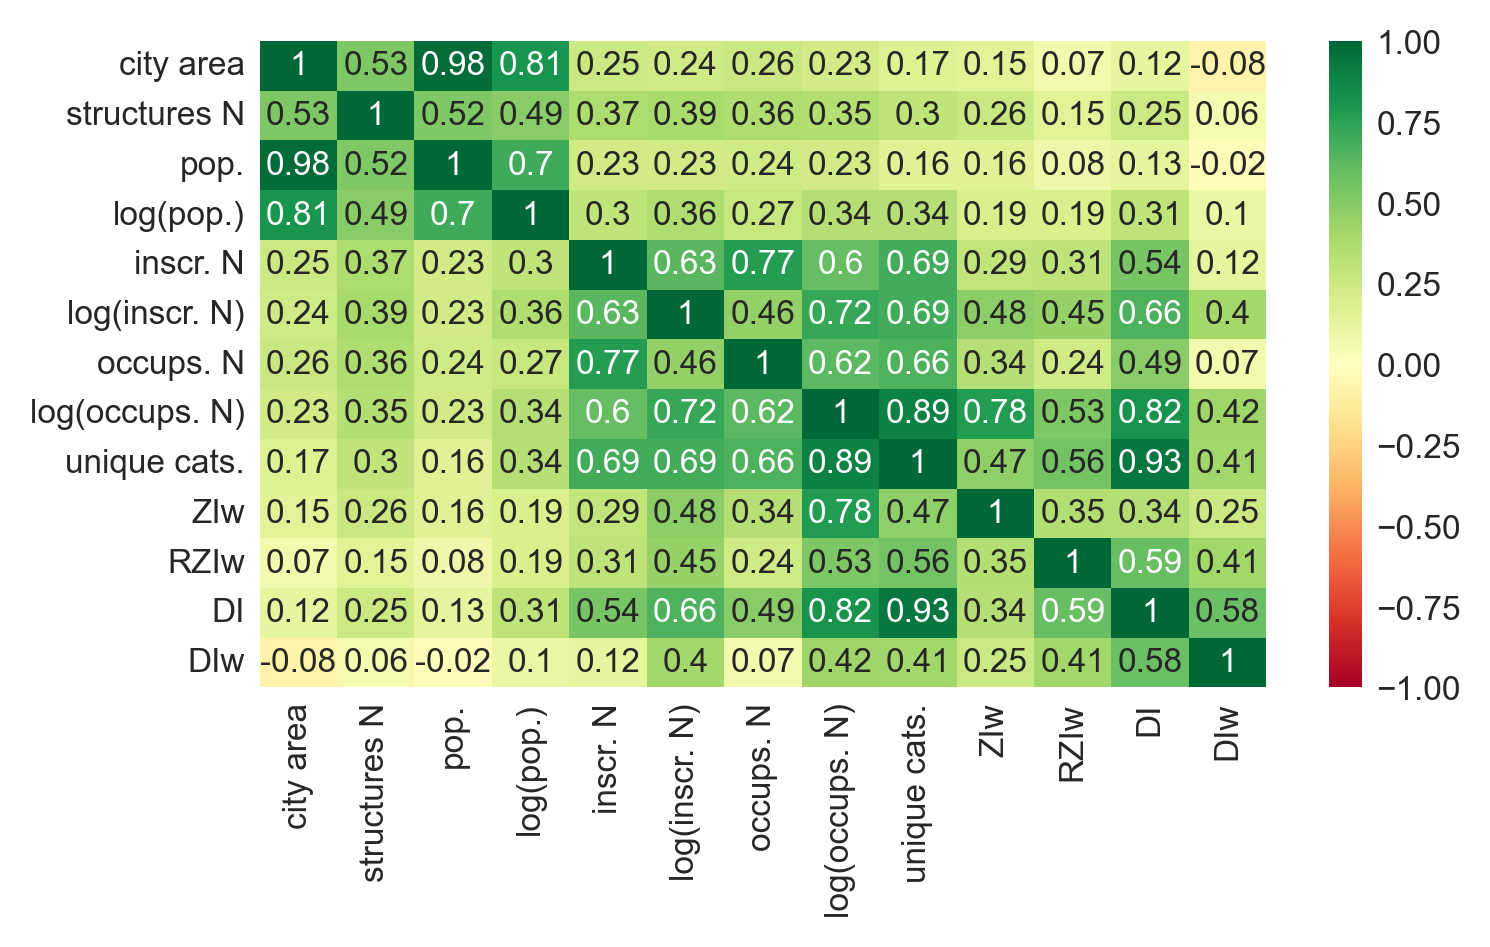

In [245]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "unique cats.","ZIw", "RZIw", "DI", "DIw"]
fig,ax=plt.subplots(figsize=(5.2,3.2), tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="RdYlGn", vmin=-1, vmax=1, annot=True)

In [246]:
save_figure(fig, "DI_ZI_corr_matrix")

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.eps"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/DI_ZI_corr_matrix.png"


In [242]:
def get_pvalue_matrix(df):
    df = df.dropna()._get_numeric_data()
    listlist_pvalues = []
    for r in df.columns:
        row_pvalues = []
        for c in df.columns:
            try:
                row_pvalues.append(round(pearsonr(df[r], df[c])[1], 2))
            except:
                row_pvalues.append(None)
        listlist_pvalues.append(row_pvalues)
    return pd.DataFrame(listlist_pvalues, columns=df.columns, index=df.columns)

In [243]:
pvalue_matrix = get_pvalue_matrix(roman_cities_wo_quant)
pvalue_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZIw,RZIw,DI,DIw
Area,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.01,0.01,0.24,0.05,0.17
num_of_structures,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.09,0.00,0.78
pop_est,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.04,0.02,0.46,0.18,0.16
pop_est_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.02,0.03,0.00,0.82
inscr_N,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.12
inscr_N_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
occups_N,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.57
occups_N_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
occups_cats_unique_N,0.01,0.00,0.04,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00
ZIw,0.01,0.00,0.02,0.02,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.01


<AxesSubplot:>

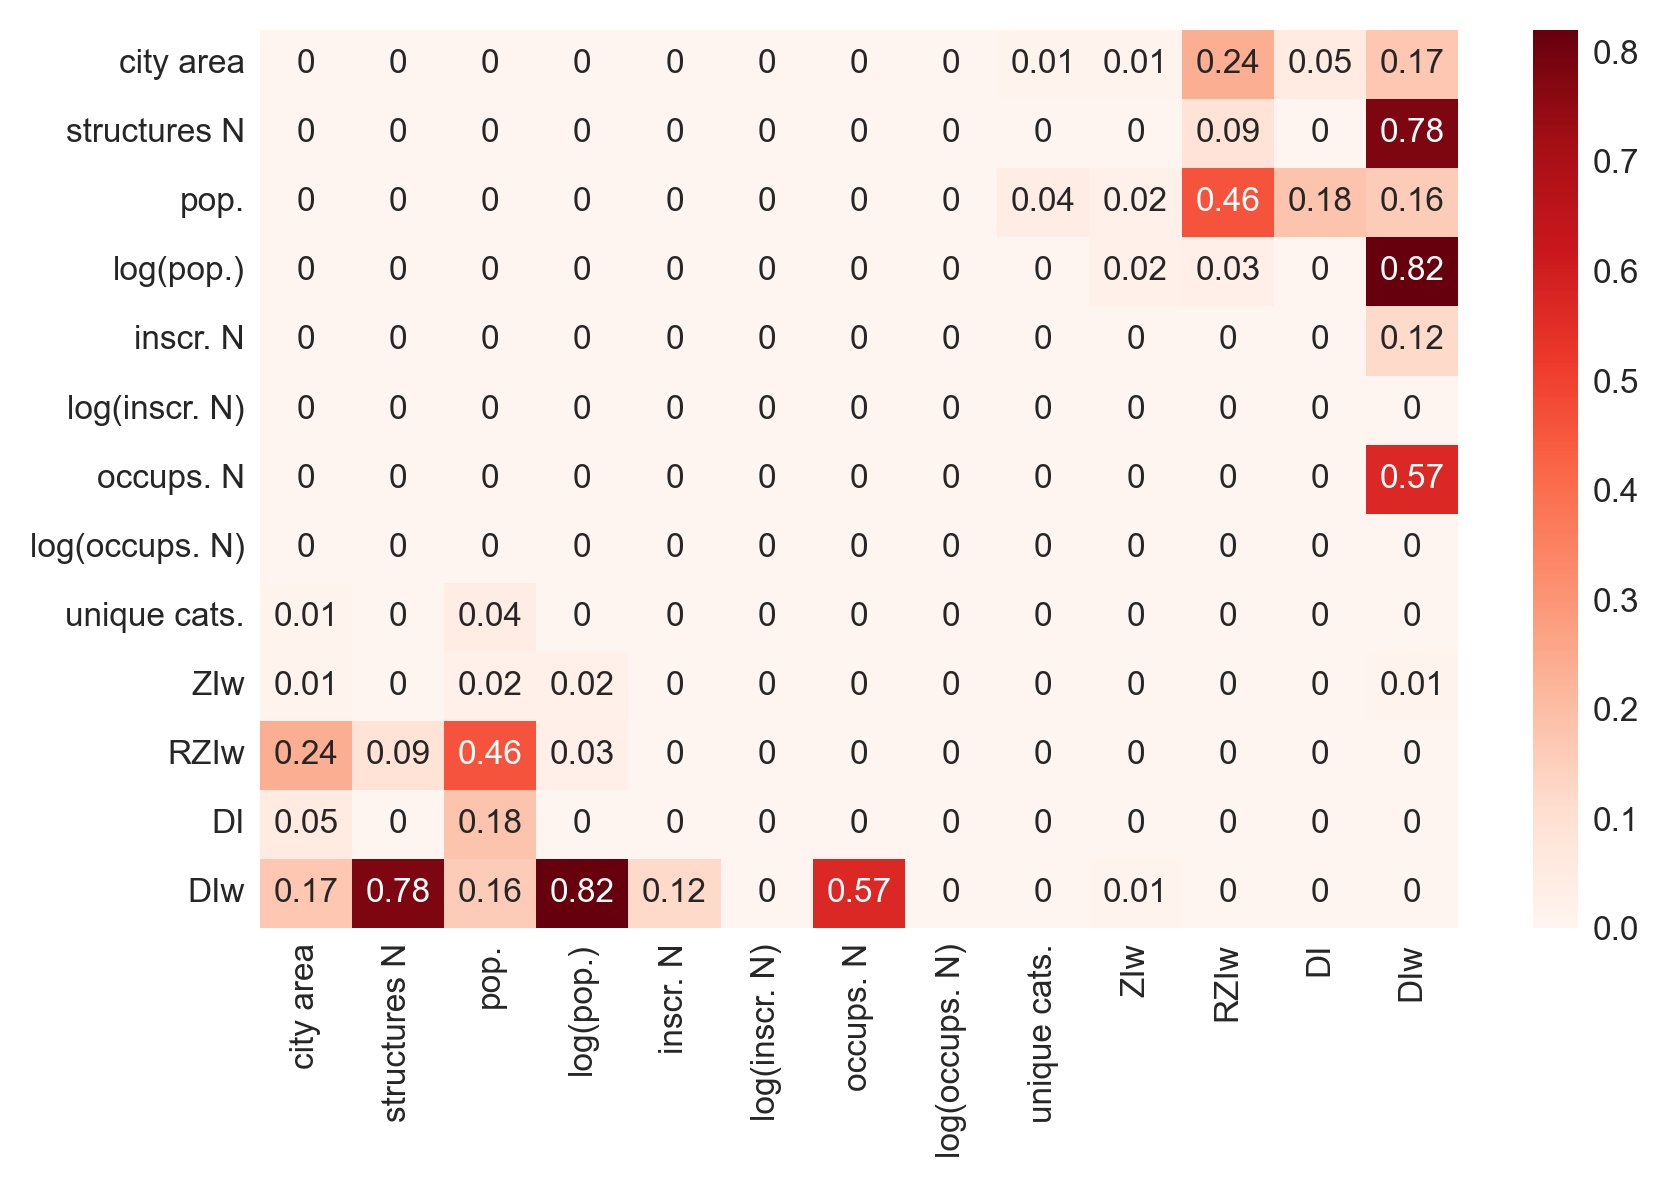

In [244]:
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(pvalue_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="Reds", annot=True)